# Banco de Dados

# Engenhariade Software

# Machine Learning

## Pre-processamento de dados

### Importando as bibliotecas

### Arranjando os dados

In [1]:
import pandas as pd

df = pd.read_excel('df_livros.xlsx')

df.nota = df.nota.apply(lambda x: 0 if x <= df['nota'].mean() else 1)

#df.drop_duplicates(subset=['titulo'], inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('data', axis=1, inplace=True)
#df.drop('isbn', axis=1, inplace=True)
df.drop('sinopse', axis=1, inplace=True)
df['titulo'] = df['titulo'].astype('string')
df['autor'] = df['autor'].astype('string')
df['editora'] = df['editora'].astype('string')
df['categoria'] = df['categoria'].astype('string')
df['acabamento'] = df['acabamento'].astype('string')

df = df.sort_values(by=['numero de vendas'], ascending=False).drop_duplicates(subset=['titulo'],keep='first')

df.dropna(inplace=True)

### Definindo as variáveis

In [2]:
X = df[['preco', 'autor', 'editora']]
y = df['nota']

### Matriz de correlação

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style="whitegrid", palette="husl")

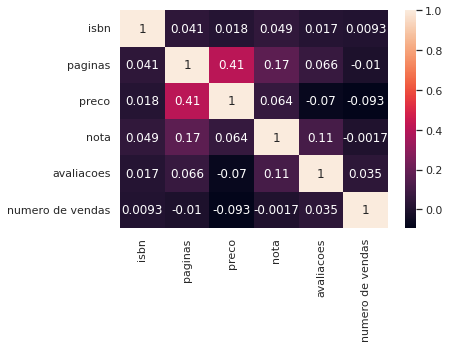

In [4]:
sns.heatmap(df.corr(), annot=True)
plt.show()

### Numerical Transformations

In [5]:
from sklearn.preprocessing import OneHotEncoder

cat_variaveis = ['autor', 'editora']
X_cat = OneHotEncoder(sparse=False, handle_unknown='ignore').fit_transform(X[cat_variaveis])

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
import numpy as np

num_variables = ['preco']
X_num = FunctionTransformer(np.log1p).fit_transform(X[num_variables])
X_num = MinMaxScaler().fit_transform(X_num)
X_num = pd.DataFrame(X_num, columns=['preco_scaled'])

X = pd.concat([X_num.reset_index(drop=True), pd.DataFrame(X_cat)], axis=1)

### Visualizando os dados numéricos não normalizados

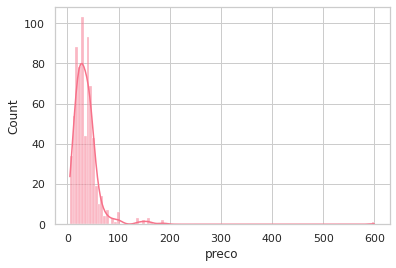

In [6]:
sns.histplot(data=df, x="preco", kde=True)
plt.show()

### Visualizando os dados numéricos normalizados

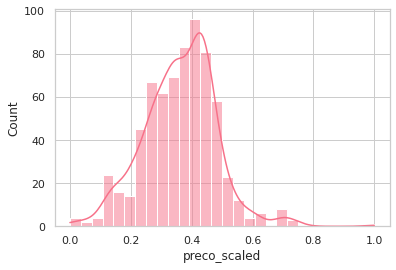

In [7]:
sns.histplot(data=X, x="preco_scaled", kde=True)
plt.show()

### Separando os dados em treinamento e teste

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, stratify=y, random_state=42, test_size=0.2)

## Baseline

In [9]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.6131386861313869

### Matriz  de confusão

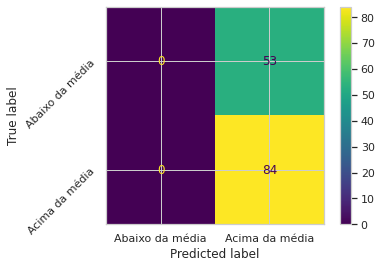

In [10]:
from sklearn.metrics import confusion_matrix

dummy_prediction = dummy.predict(X_test)
dummy_cm = confusion_matrix(y_test, dummy_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(dummy_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dummy_metricas = {'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
dummy_metricas["accuracy"].append(accuracy_score(y_test, dummy_prediction))
dummy_metricas["precision"].append(precision_score(y_test, dummy_prediction))
dummy_metricas["recall"].append(recall_score(y_test, dummy_prediction))
dummy_metricas["f1_score"].append(f1_score(y_test, dummy_prediction))

pd.DataFrame(dummy_metricas)

,accuracy,precision,recall,f1_score
0,0.613139,0.613139,1.0,0.760181


## KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(1, 20))
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=n_neighbors, weights=weights)

knn = KNeighborsClassifier()
knn = GridSearchCV(knn, param_grid, scoring='accuracy')
  
knn.fit(X_train, y_train)

print(knn.best_params_)

{'n_neighbors': 19, 'weights': 'distance'}


In [13]:
knn_param = pd.DataFrame(knn.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
knn_param['params'] = knn_param['params'].astype('string')
novo = knn_param['params'].str.split(',', expand=True)
knn_param['k'] = novo[0]
knn_param['weights'] = novo[1]
knn_param['k'] = knn_param['k'].replace("{'n_neighbors':", '', regex=True)
knn_param['weights'] = knn_param['weights'].replace("'weights': '", '', regex=True)
knn_param['weights'] = knn_param['weights'].replace("'}", '', regex=True)
knn_param['k'] = knn_param['k'].astype('int')
knn_param.drop('params', axis=1, inplace=True)

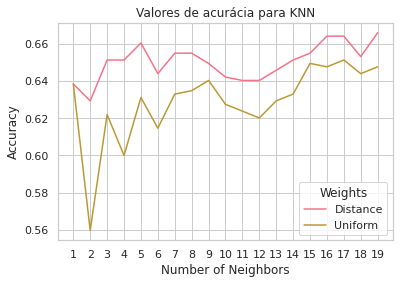

In [14]:
sns.lineplot(data=knn_param, x='k', y='mean_test_score', hue='weights')

plt.title('Valores de acurácia para KNN')

plt.ylabel('Accuracy')

plt.xlabel('Number of Neighbors')
plt.xticks(n_neighbors)

plt.legend(title='Weights', labels=['Distance', 'Uniform'])

plt.show()

#### Matriz de confusão para o melhor modelo

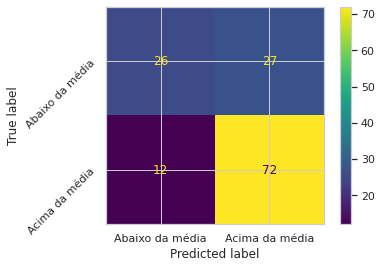

In [15]:
from sklearn.metrics import confusion_matrix

knn_prediction = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(knn_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

#### Métricas

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

knn_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
knn_metricas["accuracy"].append(accuracy_score(y_test, knn_prediction))
knn_metricas["precision"].append(precision_score(y_test, knn_prediction))
knn_metricas["recall"].append(recall_score(y_test, knn_prediction))
knn_metricas["f1_score"].append(f1_score(y_test, knn_prediction))
knn_metricas['model'].append('KNN')

knn_metricas = pd.DataFrame(knn_metricas)
knn_metricas

,model,accuracy,precision,recall,f1_score
0,KNN,0.715328,0.727273,0.857143,0.786885


In [17]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        knn_prediction,
        target_names=["livro Ruim", "livro Bom"]
    )
)

              precision    recall  f1-score   support

  livro Ruim       0.68      0.49      0.57        53
   livro Bom       0.73      0.86      0.79        84

    accuracy                           0.72       137
   macro avg       0.71      0.67      0.68       137
weighted avg       0.71      0.72      0.70       137



## Regressão Logística

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = dict(solver=solver)

log_reg = LogisticRegression()
log_reg = GridSearchCV(log_reg, param_grid, scoring='accuracy')
  
log_reg.fit(X_train, y_train)

print(log_reg.best_params_)

{'solver': 'liblinear'}


In [19]:
log_reg_param = pd.DataFrame(log_reg.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
log_reg_param

,mean_test_score,params
2,0.660550,{'solver': 'liblinear'}
0,0.658716,{'solver': 'newton-cg'}
1,0.658716,{'solver': 'lbfgs'}
3,0.658716,{'solver': 'sag'}
4,0.658716,{'solver': 'saga'}


#### Matriz de confusão para o melhor modelo

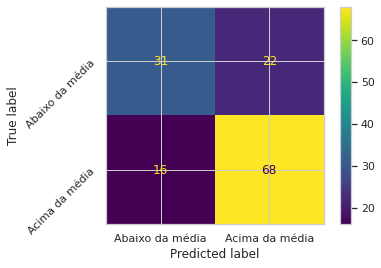

In [20]:
from sklearn.metrics import confusion_matrix

log_reg_prediction = log_reg.predict(X_test)
log_reg_cm = confusion_matrix(y_test, log_reg_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(log_reg_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

#### Métricas

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
log_reg_metricas["accuracy"].append(accuracy_score(y_test, log_reg_prediction))
log_reg_metricas["precision"].append(precision_score(y_test, log_reg_prediction))
log_reg_metricas["recall"].append(recall_score(y_test, log_reg_prediction))
log_reg_metricas["f1_score"].append(f1_score(y_test, log_reg_prediction))
log_reg_metricas["model"].append('Regressão Logística')

log_reg_metricas = pd.DataFrame(log_reg_metricas)
log_reg_metricas

,model,accuracy,precision,recall,f1_score
0,Regressão Logística,0.722628,0.755556,0.809524,0.781609


In [22]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        log_reg_prediction,
        target_names=["livro Ruim", "livro Bom"]
    )
)

              precision    recall  f1-score   support

  livro Ruim       0.66      0.58      0.62        53
   livro Bom       0.76      0.81      0.78        84

    accuracy                           0.72       137
   macro avg       0.71      0.70      0.70       137
weighted avg       0.72      0.72      0.72       137



## Naive Bayes

## SVC

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
decision_function_shape = ['ovo', 'ovr']
C = [0.1, 1, 10, 100, 1000]
gama = [1, 0.1, 0.01, 0.001, 0.0001]
param_grid = dict(C = C, kernel=kernel, decision_function_shape=decision_function_shape)

svc = SVC(probability=True)
svc = GridSearchCV(svc, param_grid, scoring='accuracy')
  
svc.fit(X_train, y_train)

print(svc.best_params_)

{'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}


In [24]:
svc_param = pd.DataFrame(svc.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
svc_param['params'] = svc_param['params'].astype('string')
novo = svc_param['params'].str.split(',', expand=True)
svc_param['decision_function_shape'] = novo[0]
svc_param['kernel'] = novo[1]
svc_param['decision_function_shape'] = svc_param['decision_function_shape'].replace("{'decision_function_shape': '", '', regex=True)
svc_param['decision_function_shape'] = svc_param['decision_function_shape'].replace("'", '', regex=True)
svc_param['kernel'] = svc_param['kernel'].replace("'kernel': '", '', regex=True)
svc_param['kernel'] = svc_param['kernel'].replace("'}", '', regex=True)
svc_param.drop('params', axis=1, inplace=True)

In [25]:
svc_param.groupby(['kernel', 'decision_function_shape']).mean()

mean_test_score
kernel                           decision_function_shape                 
'decision_function_shape': 'ovo' {C: 0.1                         0.610550
                                 {C: 1                           0.662385
                                 {C: 10                          0.655046
                                 {C: 100                         0.629817
                                 {C: 1000                        0.620183
'decision_function_shape': 'ovr' {C: 0.1                         0.610550
                                 {C: 1                           0.662385
                                 {C: 10                          0.655046
                                 {C: 100                         0.629817
                                 {C: 1000                        0.620183

#### Matriz de confusão para o melhor modelo

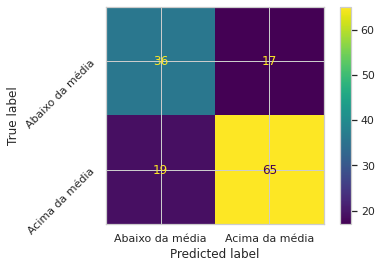

In [26]:
from sklearn.metrics import confusion_matrix

svc_prediction = svc.predict(X_test)
svc_cm = confusion_matrix(y_test, svc_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(svc_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

#### Métricas

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svc_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
svc_metricas["accuracy"].append(accuracy_score(y_test, svc_prediction))
svc_metricas["precision"].append(precision_score(y_test, svc_prediction))
svc_metricas["recall"].append(recall_score(y_test, svc_prediction))
svc_metricas["f1_score"].append(f1_score(y_test, svc_prediction))
svc_metricas["model"].append('SVC')

svc_metricas = pd.DataFrame(svc_metricas)
svc_metricas

,model,accuracy,precision,recall,f1_score
0,SVC,0.737226,0.792683,0.77381,0.783133


In [28]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        svc_prediction,
        target_names=["livro Ruim", "livro Bom"]
    )
)

              precision    recall  f1-score   support

  livro Ruim       0.65      0.68      0.67        53
   livro Bom       0.79      0.77      0.78        84

    accuracy                           0.74       137
   macro avg       0.72      0.73      0.72       137
weighted avg       0.74      0.74      0.74       137



## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

criterion = ['gini', 'entropy', 'log_loss']
max_depths = list(range(1, 20))
param_grid = dict(criterion=criterion, max_depth=max_depths)

dtc = DecisionTreeClassifier()
dtc = GridSearchCV(dtc, param_grid, scoring='accuracy')

dtc.fit(X_train, y_train)

print(dtc.best_params_)

{'criterion': 'entropy', 'max_depth': 4}


### Árvore

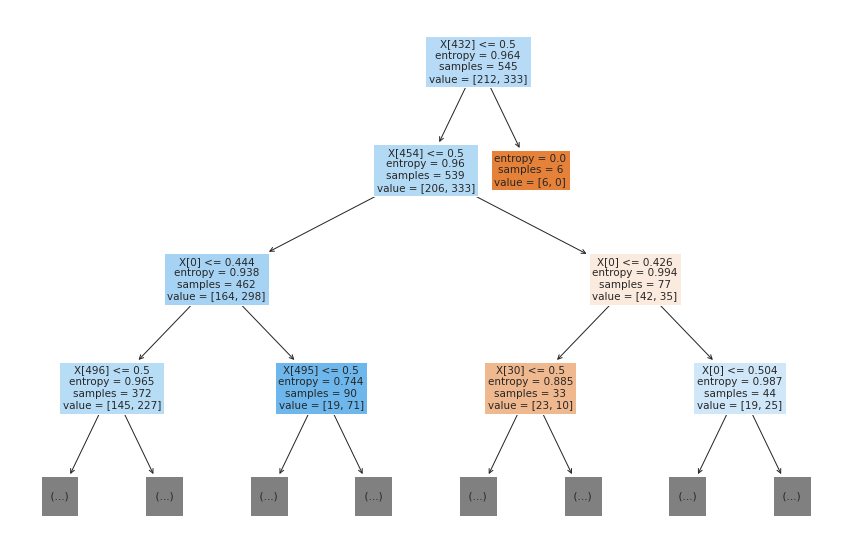

In [30]:
from sklearn import tree

fig = plt.figure(figsize=(15,10)) #Aumentar a fonte da figura
arvore_bonitinha = tree.plot_tree(dtc.best_estimator_, filled=True, max_depth=3)
plt.show()

In [31]:
dtc_param = pd.DataFrame(dtc.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
dtc_param['params'] = dtc_param['params'].astype('string')
novo = dtc_param['params'].str.split(',', expand=True)
dtc_param['criterion'] = novo[0]
dtc_param['max_depth'] = novo[1]
dtc_param['criterion'] = dtc_param['criterion'].replace("{'criterion': '", '', regex=True)
dtc_param['criterion'] = dtc_param['criterion'].replace("'", '', regex=True)
dtc_param['max_depth'] = dtc_param['max_depth'].replace("'max_depth': ", '', regex=True)
dtc_param['max_depth'] = dtc_param['max_depth'].replace("}", '', regex=True)
dtc_param['max_depth'] = dtc_param['max_depth'].astype('int')
dtc_param.drop('params', axis=1, inplace=True)

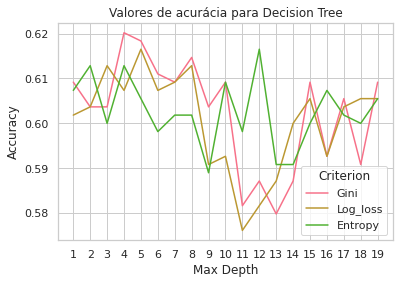

In [32]:
sns.lineplot(data=dtc_param, x='max_depth', y='mean_test_score', hue='criterion')

plt.title('Valores de acurácia para Decision Tree')

plt.ylabel('Accuracy')

plt.xlabel('Max Depth')
plt.xticks(max_depths)

plt.legend(title='Criterion', labels=['Gini', 'Log_loss', 'Entropy'], loc='lower right')

plt.show()

### Matriz de confusão para o melhor modelo

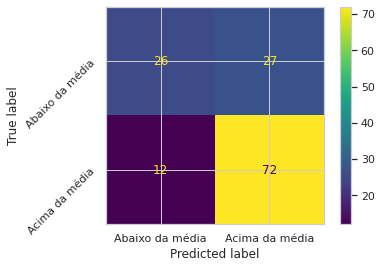

In [33]:
from sklearn.metrics import confusion_matrix

dtc_prediction = dtc.predict(X_test)
dtc_cm = confusion_matrix(y_test, knn_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(dtc_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dtc_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
dtc_metricas["accuracy"].append(accuracy_score(y_test, dtc_prediction))
dtc_metricas["precision"].append(precision_score(y_test, dtc_prediction))
dtc_metricas["recall"].append(recall_score(y_test, dtc_prediction))
dtc_metricas["f1_score"].append(f1_score(y_test, dtc_prediction))
dtc_metricas['model'].append('Decision Tree')

dtc_metricas = pd.DataFrame(dtc_metricas)
dtc_metricas

,model,accuracy,precision,recall,f1_score
0,Decision Tree,0.678832,0.663934,0.964286,0.786408


In [35]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        dtc_prediction,
        target_names=["livro Ruim", "livro Bom"]
    )
)

              precision    recall  f1-score   support

  livro Ruim       0.80      0.23      0.35        53
   livro Bom       0.66      0.96      0.79        84

    accuracy                           0.68       137
   macro avg       0.73      0.60      0.57       137
weighted avg       0.72      0.68      0.62       137



## Comparando os modelos

In [36]:
compara = pd.concat([knn_metricas, log_reg_metricas, svc_metricas, dtc_metricas])
compara.set_index('model', inplace=True)
compara

,accuracy,precision,recall,f1_score
model,,,,
KNN,0.715328,0.727273,0.857143,0.786885
Regressão Logística,0.722628,0.755556,0.809524,0.781609
SVC,0.737226,0.792683,0.773810,0.783133
Decision Tree,0.678832,0.663934,0.964286,0.786408


In [37]:
from sklearn.metrics import roc_auc_score

knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]).round(2)
log_reg_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]).round(2)
svc_auc = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]).round(2)
dtc_auc = roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1]).round(2)
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1]).round(2)

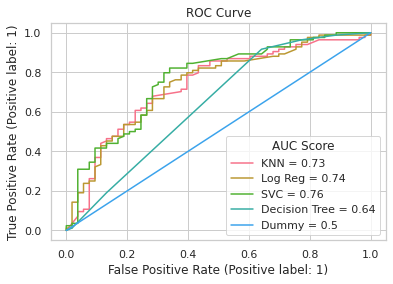

In [38]:
from sklearn.metrics import RocCurveDisplay

#knn_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test)
#plt.figure(figsize=(6,6)) 

ax = plt.gca()

knn_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax)
log_reg_disp = RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax)
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax)
dtc_disp = RocCurveDisplay.from_estimator(dtc, X_test, y_test, ax=ax)
dummy_disp = RocCurveDisplay.from_estimator(dummy, X_test, y_test, ax=ax)

plt.title('ROC Curve')

plt.legend(
    title='AUC Score',
    labels=[f'KNN = {knn_auc}', f'Log Reg = {log_reg_auc}', f'SVC = {svc_auc}', f'Decision Tree = {dtc_auc}',  f'Dummy = {dummy_auc}'],
    loc='lower right'
)

plt.show()

## Joblib

In [39]:
from joblib import dump

dump(knn, 'joblib/knn.joblib')
dump(log_reg, 'joblib/log_reg.joblib')
dump(svc, 'joblib/svc.joblib')
dump(dtc, 'joblib/dtc.joblib')
dump(X_test, 'joblib/X.joblib')
dump(y_test, 'joblib/y.joblib');

## Pickle

In [40]:
import pickle
s = pickle.dumps(knn)
knn2 = pickle.loads(s)
knn2.score(X_test, y_test)

0.7153284671532847